In [39]:
import mbuild as mb
import numpy as np
import warnings
import math
import matplotlib.pyplot as plt
from jinja2 import Template
warnings.filterwarnings('ignore')

This notebook will demonstrate how to perform automated exploration of the torsional energy, using mbuild to generate input configurations for nwchem.

In [40]:
ethane_comp = mb.load('CC', smiles=True)

Let us print out the order of the particles in the compound to figure out which indices are the two carbon atoms.  We'll need these to do the rotation.

In [41]:
for particle in ethane_comp.particles(): print(particle)

<C pos=([-0.0759  0.0018  0.0021]), 4 bonds, id: 5873243600>
<C pos=([ 0.0759 -0.0018 -0.0021]), 4 bonds, id: 5871522448>
<H pos=([-0.1141 -0.0854  0.0593]), 1 bonds, id: 5874656464>
<H pos=([-0.1099  0.0954  0.0513]), 1 bonds, id: 5874758736>
<H pos=([-0.1165 -0.0018 -0.1012]), 1 bonds, id: 5874703376>
<H pos=([ 0.1099 -0.0954 -0.0513]), 1 bonds, id: 5852421136>
<H pos=([ 0.1141  0.0854 -0.0593]), 1 bonds, id: 5874334864>
<H pos=([0.1165 0.0018 0.1012]), 1 bonds, id: 5874864592>


The first two particles correspond to the carbons, so we just need to pass these, as a tuple, to the rotate_dihedral function. 

The function below will create an input file for nwchem based on a jinja template.

In [4]:
def create_file(dir, config, template='esp.nw.jinja' ):
    fname = f'{dir}/esp.nw'
    data = {'config': config}
    
    
    if isinstance(template, str):
        with open(template, "r") as f:
            template = Template(f.read())
            
    rendered = template.render(data)
    with open(fname, "w") as f:
        f.write(rendered)
        

First, let us run the esp_init.nw file, which will first perform geometry optimization before calculating the energy.  This will just ensure we are starting from a low energy state. 

In [42]:
temp = mb.clone(ethane_comp)
msg = f'mkdir -p phi0'
!{msg}

# format the mbuild particles for nwchem input file
formatted_configuration = ''
for particle in temp.particles():
    formatted_configuration += f'{particle.name}\t{particle.pos[0]*10.0}\t{particle.pos[1]*10.0}\t{particle.pos[2]*10.0}\n'

create_file(dir = f'phi0', config =formatted_configuration,  template='esp_init.nw.jinja')

msg = f'cd phi0 && mpirun -np 2 nwchem esp.nw > output.out'
!{msg}


We need to parse the output file to get the updated coordinates and grab the energy.  

In [51]:
def parse_output(filename):
    file = open(filename)
    
    # reading the file as a list line by line
    content = file.readlines()
    
    find_last = True
    energy_fetch = True
    energy = 0
    coords = []
    for i in range(len(content)-1, 0, -1):
        if 'task_energy%begin%cartesian coordinates' in content[i] and find_last==True:
            for j in range(1, ethane_comp.n_particles+1):
                coords.append([float(p) for p in content[i+j].replace('\n','').strip().split(' ')])
                find_last = False
        if 'task_energy%end%total energy' in content[i] and energy_fetch == True:
            energy = float(content[i-1])
            energy_fetch = False
    # closing the file
    file.close()
    return energy, coords

energy_list = []
phi_list = []
# opening the data file
file = "phi0/ecce.out"
energy, coords = parse_output(file)
# reading the file as a list line by line

energy_list.append(energy)
phi_list.append(0)

#update the coordinates
minimized = mb.clone(ethane_comp)
for i, particle in enumerate(minimized.particles()):
    particle.pos = np.array(coords[i])/10.0

In [52]:
max = 100
for i in range(1,max):
    
    temp = mb.clone(minimized)
    phi=round(i*2.0*math.pi/float(max),3)
    temp.rotate_dihedral((temp.children[0], temp.children[1]),phi=phi )
     
    formatted_configuration = ''
    for particle in temp.particles():
        formatted_configuration += f'{particle.name}\t{particle.pos[0]*10.0}\t{particle.pos[1]*10.0}\t{particle.pos[2]*10.0}\n'

    msg = f'mkdir -p phi{phi}'
    
    !{msg}
    create_file(dir = f'phi{phi}', config =formatted_configuration,  template='esp.nw.jinja')

    msg = f'cd phi{phi} && mpirun -np 2 nwchem esp.nw > output.out'
    !{msg}
    if i%10 == 0:
        print(f'completed step {i} of {max}')
   

    energy, coords = parse_output(f'phi{phi}/ecce.out')
    
    if energy != 0:
        energy_list.append(energy)
        phi_list.append(phi)    
    

completed step 10 of 100
--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MB22.local
  System call: unlink(2) /var/folders/zy/g3vg1tz11yj0mq1721gql95c0000gn/T//ompi.MB22.501/pid.54228/1/vader_segment.MB22.501.4cef0001.0
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------
completed step 20 of 100
completed step 30 of 100
completed step 40 of 100
completed step 50 of 100
completed step 60 of 100
completed step 70 of 100
completed step 80 of 100
completed step 90 of 100


Let us plot the result.  Note, I'm just going to assume our starting configuration has a phi value of 60 degrees, as we started in the energy minimized staggered configuration. To be rigorous this should actually be calculated.  Energy barrier of about 3.1 kcal/mol agrees well with prior calculations and experiment.  

To do:
- Calculation of the initial phi to be more rigorous with my shifting.
- Include restraints on the dihedral of interest, such that geometry optimization of the rest of the molecule can be performed before energy calculation. This shouldn't be a major favor for ethane, but might for a more complex molecule
-  Set up template to accept different QM approaches (e.g. MP2 vs RHF).

max barrier height:  3.1  kcal/mol


Text(0, 0.5, 'energy kcal/mol ')

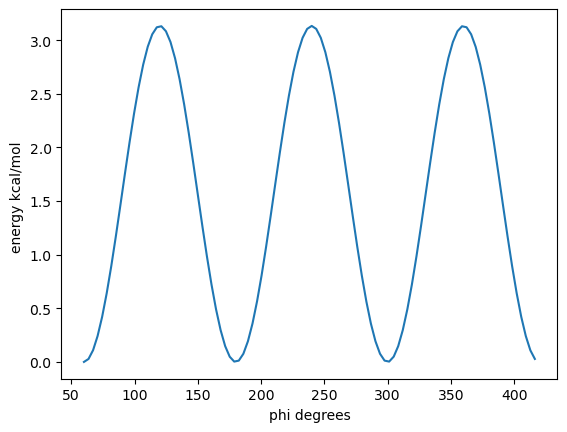

In [59]:
zeroed = []
for energy in energy_list:
    zeroed.append((energy-energy_list[0])* 627.50956)
angles = []
for phi in phi_list:
    angles.append(60+phi*180.0/math.pi)

print("max barrier height: ", round(np.max(np.array(zeroed)), 1), ' kcal/mol')
fig, ax = plt.subplots(1,1)
ax.plot(angles, zeroed)
ax.set_xlabel('phi degrees')
ax.set_ylabel('energy kcal/mol ')